In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
from conviction_helpers import *
from conviction_system_logic3 import *
from bonding_curve_eq import *

This notebook uses the differential games framework developed by BlockScience. It is currently in private beta, and building towards a full open source release.

**Description:**

cadCAD is a Python library that assists in the processes of designing, testing and validating complex systems through simulation. At its core, cadCAD is a differential games engine that supports parameter sweeping and Monte Carlo analyses and can be easily integrated with other scientific computing Python modules and data science workflows.

To learn more about cadCAD, follow our [tutorial series](https://github.com/BlockScience/cadCAD-Tutorials/tree/master/01%20Tutorials)

**Installing cadCAD:**

cadCAD is in private beta. Tokens are issued to participants. Replace `<TOKEN>` in the installation URL below
```bash
pip3 install cadCAD --extra-index-url https://<TOKEN>@repo.fury.io/blockscience/
```

If you'd like to participate in the beta program, contact cadcad [at] block [dot] science.


In [2]:
#THIS policy is one of the main paramters of this system!

#maximum share of funds a proposal can take
default_beta = .2 #later we should set this to be param so we can sweep it
# tuning param for the trigger function
default_rho = .5*default_beta**2

def trigger_threshold(requested, funds, supply, beta=default_beta , rho=default_rho):
    
    share = requested/funds
    if share < beta:
        return rho*supply/(beta-share)**2
    else: 
        return np.inf

In [3]:
dict1 = trigger_sweep('token_supply',trigger_threshold)

/Users/Zargham/Documents/GitHub/conviction/conviction_helpers.py:212: RuntimeWarning: divide by zero encountered in log10
  demo_data_Z0[sof_ind,ts_ind] = np.log10(trigger)
/Users/Zargham/Documents/GitHub/conviction/conviction_helpers.py:214: RuntimeWarning: invalid value encountered in double_scalars
  demo_data_Z2[sof_ind,ts_ind] = trigger/tc #share of maximum possible conviction
/Users/Zargham/Documents/GitHub/conviction/conviction_helpers.py:215: RuntimeWarning: invalid value encountered in double_scalars
  demo_data_Z3[sof_ind,ts_ind] = np.log10(trigger/tc)


Text(0.15940000000000001, 1008990000.0, 'fixed alpha = 0.5')

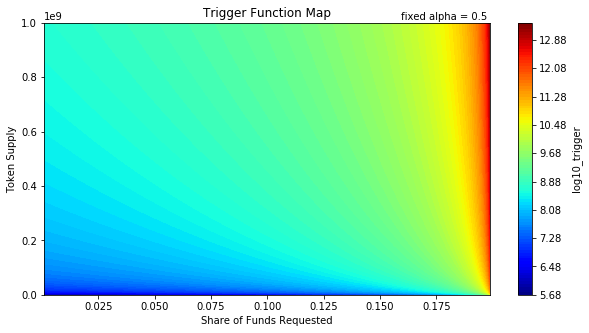

In [4]:
trigger_plotter(dict1['share_of_funds'],
                dict1['log10_trigger'], 
                'log10_trigger',
                dict1['total_supply'],
                'Token Supply')
axis = plt.axis()
plt.text(.2*axis[0]+.8*axis[1],axis[-1]*1.01, 'fixed alpha = 0.5')

In [5]:
dict2 = trigger_sweep('alpha',trigger_threshold)

In [6]:
dict2.keys()

dict_keys(['log10_trigger', 'trigger', 'share_of_max_conv', 'log10_share_of_max_conv', 'alpha', 'share_of_funds'])

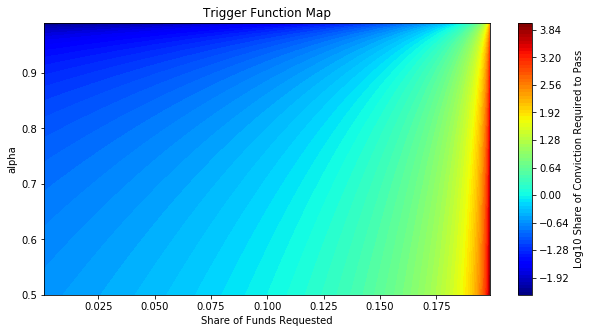

In [7]:
trigger_plotter(dict2['share_of_funds'],
                dict2['log10_share_of_max_conv'], 
                'Log10 Share of Conviction Required to Pass',
                dict2['alpha'],
                'alpha')


In [8]:
n= 60 #initial participants
m= 3 #initial proposals

initial_sentiment = .6

theta =.35
kappa = 6
sale_price = .1

def TFGTS(total_supply):
    #wrap initializer params to pass the function correctly
    return total_funds_given_total_supply(total_supply, theta = theta, initial_price = sale_price) 


In [9]:
#initializers
network, initial_funds, initial_supply, total_requested = initialize_network(n,m,TFGTS,trigger_threshold)
initial_reserve, invariant, initial_price= initialize_bonding_curve(initial_supply, initial_price = sale_price, kappa =kappa, theta = theta)

In [10]:
invariant

1.7955407857599857e+31

In [11]:
proposals = get_nodes_by_type(network, 'proposal')
participants = get_nodes_by_type(network, 'participant')

supporters = get_edges_by_type(network, 'support')
influencers = get_edges_by_type(network, 'influence')
competitors = get_edges_by_type(network, 'conflict')

In [12]:
initial_reserve

67040.16629275207

In [13]:
initial_funds

36098.55108071265

In [14]:
#sample proposal
network.nodes[proposals[0]]

{'type': 'proposal',
 'conviction': 0,
 'status': 'candidate',
 'age': 0,
 'funds_requested': 11443.91427929522,
 'trigger': inf}

In [15]:
#sample participant
network.nodes[participants[0]]

{'type': 'participant',
 'holdings': 5718.0718806896575,
 'sentiment': 0.17859148389446788}

In [16]:
#sample relationship participant to proposal
network.edges[supporters[0]]

{'affinity': 0.4047245410553306,
 'tokens': 0,
 'conviction': 0,
 'type': 'support'}

In [17]:
network.edges[influencers[0]]

{'influence': 4.314493792217198, 'type': 'influence'}

In [18]:
network.edges[competitors[0]]

{'conflict': 0.8304060260811613, 'type': 'conflict'}

Text(0.5, 1.0, 'Participants Social Network')

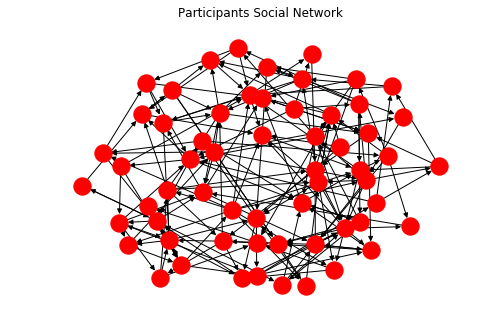

In [19]:
nx.draw_kamada_kawai(network, nodelist = participants, edgelist=influencers)
plt.title('Participants Social Network')

Text(0.5, 1.0, 'Proposals Conflict Network')

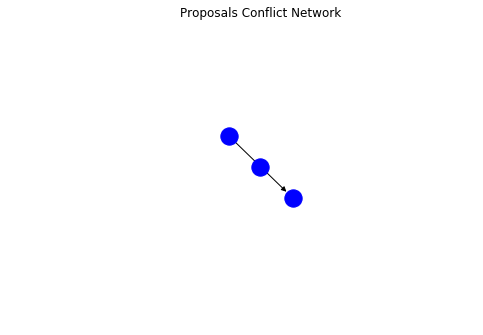

In [20]:
nx.draw_kamada_kawai(network, nodelist = proposals, edgelist=competitors, node_color='b')
plt.title('Proposals Conflict Network')

Text(0.5, 1.0, 'Histogram of Participants Token Holdings')

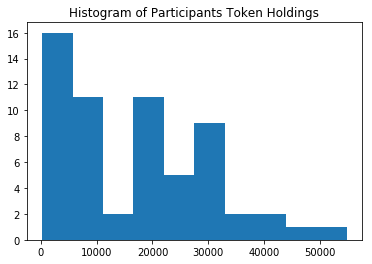

In [21]:
plt.hist([ network.nodes[i]['holdings'] for i in participants])
plt.title('Histogram of Participants Token Holdings')

Text(0.5, 1.0, 'Histogram of Proposals Funds Requested')

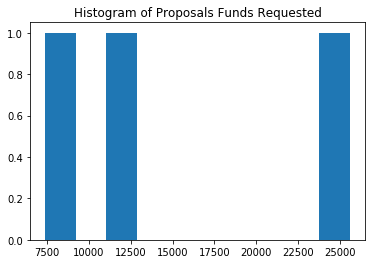

In [22]:
plt.hist([ network.nodes[i]['funds_requested'] for i in proposals])
plt.title('Histogram of Proposals Funds Requested')

In [23]:
affinities = np.empty((n,m))
for i_ind in range(n):
    for j_ind in range(m):
        i = participants[i_ind]
        j = proposals[j_ind]
        affinities[i_ind][j_ind] = network.edges[(i,j)]['affinity']

Text(0.5, 137.58, 'participant_id')

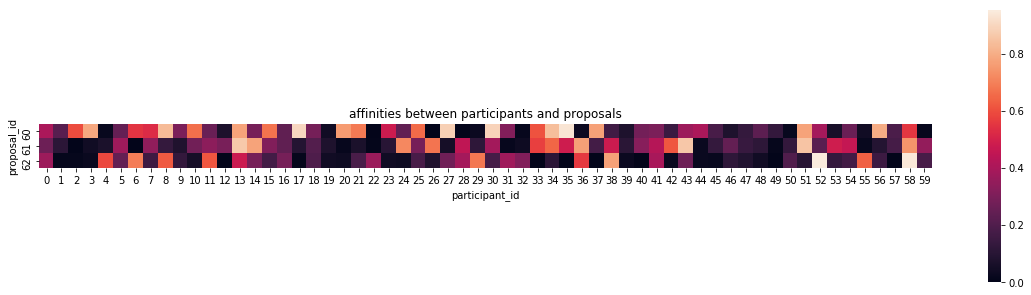

In [24]:
dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities.T,
            xticklabels=participants,
            yticklabels=proposals,
            square=True,
            cbar=True,
            ax=ax)

plt.title('affinities between participants and proposals')
plt.ylabel('proposal_id')
plt.xlabel('participant_id')

In [25]:
#power of 1 token forever
conviction_capacity = [2,5,10]
alpha = [1-1/cc for cc in conviction_capacity]
print(alpha)

[0.5, 0.8, 0.9]


In [26]:
params= {
    'sensitivity': [.75],
    'tmin': [7], #unit days; minimum periods passed before a proposal can pass
    'min_supp':[50], #number of tokens that must be stake for a proposal to be a candidate
    'sentiment_decay': [.01], #termed mu in the state update function
    'alpha': alpha,
    'base_completion_rate': [100],
    'base_failure_rate': [200],
    'trigger_func': [trigger_threshold],
    'kappa': [kappa], #bonding curve curvature
    'invariant': [invariant], #set by bonding curve choices
    'tax_rate': [.02]
    }

In [27]:
type(trigger_threshold)

function

In [28]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
time_periods_per_run = 100
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [29]:
simulation_parameters

[{'N': 1,
  'T': range(0, 100),
  'M': {'sensitivity': 0.75,
   'tmin': 7,
   'min_supp': 50,
   'sentiment_decay': 0.01,
   'alpha': 0.5,
   'base_completion_rate': 100,
   'base_failure_rate': 200,
   'trigger_func': <function __main__.trigger_threshold(requested, funds, supply, beta=0.2, rho=0.020000000000000004)>,
   'kappa': 6,
   'invariant': 1.7955407857599857e+31,
   'tax_rate': 0.02}},
 {'N': 1,
  'T': range(0, 100),
  'M': {'sensitivity': 0.75,
   'tmin': 7,
   'min_supp': 50,
   'sentiment_decay': 0.01,
   'alpha': 0.8,
   'base_completion_rate': 100,
   'base_failure_rate': 200,
   'trigger_func': <function __main__.trigger_threshold(requested, funds, supply, beta=0.2, rho=0.020000000000000004)>,
   'kappa': 6,
   'invariant': 1.7955407857599857e+31,
   'tax_rate': 0.02}},
 {'N': 1,
  'T': range(0, 100),
  'M': {'sensitivity': 0.75,
   'tmin': 7,
   'min_supp': 50,
   'sentiment_decay': 0.01,
   'alpha': 0.9,
   'base_completion_rate': 100,
   'base_failure_rate': 200,
   '

In [30]:
initial_conditions = {'network':network,
                      'supply': initial_supply,
                      'funds':initial_funds,
                      'reserve': initial_reserve,
                      'spot_price': initial_price,
                      'sentiment': initial_sentiment}

In [31]:
initial_conditions

{'network': <networkx.classes.digraph.DiGraph at 0x1a1cec28d0>,
 'supply': 1031387.173734647,
 'funds': 36098.55108071265,
 'reserve': 67040.16629275207,
 'spot_price': 0.3900000000000005,
 'sentiment': 0.6}

In [32]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': driving_process
        },
        'variables': {
            'network': update_network,
            'funds':increment_funds,
            'supply':increment_supply,
            'reserve': increment_reserve
        }
    },
    {
      'policies': {
          'completion': check_progress #see if any of the funded proposals completes
        },
        'variables': { # The following state variables will be updated simultaneously
            'sentiment': update_sentiment_on_completion, #note completing decays sentiment, completing bumps it
            'network': complete_proposal #book-keeping
        }
    },
        {
      'policies': {
          'release': trigger_function #check each proposal to see if it passes
        },
        'variables': { # The following state variables will be updated simultaneously
            'funds': decrement_funds, #funds expended
            'sentiment': update_sentiment_on_release, #releasing funds can bump sentiment
            'network': update_proposals #reset convictions, and participants sentiments
                                        #update based on affinities
        }
    },
    { 
        'policies': { 
            #currently naive decisions; future: strategic
            'participants_act': participants_decisions, #high sentiment, high affinity =>buy
                                                        #low sentiment, low affinities => burn
                                                        #assign tokens to top affinities
        },
        'variables': {
            'supply': update_supply, #book-keeping from participants decisions
            'reserve': update_reserve, #funds under the bonding curve
            'spot_price': update_price, #new bonding curve spot price
            'funds': update_funds, #capture taxes
            'network': update_tokens #update everyones holdings 
                                    #and their conviction for each proposal
        }
    }
]

In [33]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

In [34]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [35]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    

multi_proc: [<cadCAD.configuration.Configuration object at 0x1a1d8d0ef0>, <cadCAD.configuration.Configuration object at 0x1a1d3baa90>, <cadCAD.configuration.Configuration object at 0x1a1d8e60b8>]
[<cadCAD.configuration.Configuration object at 0x1a1d8d0ef0>, <cadCAD.configuration.Configuration object at 0x1a1d3baa90>, <cadCAD.configuration.Configuration object at 0x1a1d8e60b8>]


In [36]:
params['kappa']

[6]

In [38]:
params

{'sensitivity': [0.75],
 'tmin': [7],
 'min_supp': [50],
 'sentiment_decay': [0.01],
 'alpha': [0.5, 0.8, 0.9],
 'base_completion_rate': [100],
 'base_failure_rate': [200],
 'trigger_func': [<function __main__.trigger_threshold(requested, funds, supply, beta=0.2, rho=0.020000000000000004)>],
 'kappa': [6],
 'invariant': [1.7955407857599857e+31],
 'tax_rate': [0.02]}

{'N': 1, 'T': range(0, 100), 'M': {'sensitivity': 0.75, 'tmin': 7, 'min_supp': 50, 'sentiment_decay': 0.01, 'alpha': 0.5, 'base_completion_rate': 100, 'base_failure_rate': 200, 'trigger_func': <function trigger_threshold at 0x1a1b921bf8>, 'kappa': 6, 'invariant': 1.7955407857599857e+31, 'tax_rate': 0.02}}


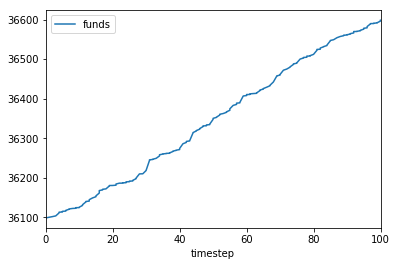

{'N': 1, 'T': range(0, 100), 'M': {'sensitivity': 0.75, 'tmin': 7, 'min_supp': 50, 'sentiment_decay': 0.01, 'alpha': 0.8, 'base_completion_rate': 100, 'base_failure_rate': 200, 'trigger_func': <function trigger_threshold at 0x1a1b921bf8>, 'kappa': 6, 'invariant': 1.7955407857599857e+31, 'tax_rate': 0.02}}


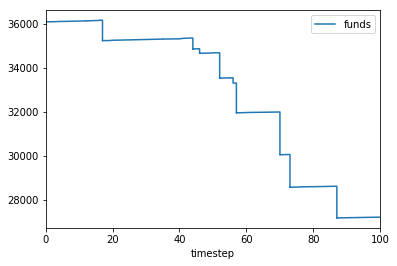

{'N': 1, 'T': range(0, 100), 'M': {'sensitivity': 0.75, 'tmin': 7, 'min_supp': 50, 'sentiment_decay': 0.01, 'alpha': 0.9, 'base_completion_rate': 100, 'base_failure_rate': 200, 'trigger_func': <function trigger_threshold at 0x1a1b921bf8>, 'kappa': 6, 'invariant': 1.7955407857599857e+31, 'tax_rate': 0.02}}


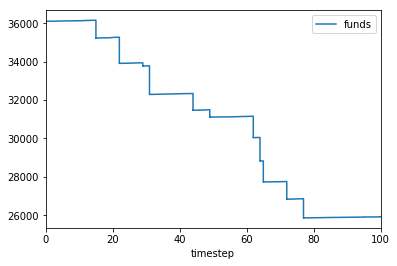

In [76]:
for ind in range(len(results)):
    r=results[ind]['result']
    print(results[ind]['simulation_parameters'])
    r.plot(x='timestep', y='funds')
    plt.show()

In [78]:
#I ran multiple experiments above, pick1
experiment_index = 2
df = results[experiment_index]['result']

In [79]:
df['conviction'] = df.network.apply(lambda g: np.array([g.nodes[j]['conviction'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['candidate_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['candidate_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['killed_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='killed']))
df['killed_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='killed']))
df['candidate_funds_requested'] = df.network.apply(lambda g: np.array([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate']))
df['active_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='active']))
df['active_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='active']))
df['failed_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='failed']))
df['failed_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='failed']))
df['completed_count'] = df.network.apply(lambda g: len([j for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='completed']))
df['completed_funds'] = df.network.apply(lambda g: np.sum([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='completed']))

In [80]:
df['funds_requested'] = df.network.apply(lambda g: np.array([g.nodes[j]['funds_requested'] for j in get_nodes_by_type(g, 'proposal')]))
df['share_of_funds_requested'] = df.candidate_funds_requested/df.funds

df['share_of_funds_requested_all'] = df.funds_requested/df.funds

In [81]:
df['triggers'] = df.network.apply(lambda g: np.array([g.nodes[j]['trigger'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate' ]))
df['conviction_share_of_trigger'] = df.conviction/df.triggers
df['age'] = df.network.apply(lambda g: np.array([g.nodes[j]['age'] for j in get_nodes_by_type(g, 'proposal') if g.nodes[j]['status']=='candidate' ]))

In [82]:
df['age_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['age'] for j in get_nodes_by_type(g, 'proposal') ]))
df['conviction_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['conviction'] for j in get_nodes_by_type(g, 'proposal') ]))
df['triggers_all'] = df.network.apply(lambda g: np.array([g.nodes[j]['trigger'] for j in get_nodes_by_type(g, 'proposal')  ]))

df['conviction_share_of_trigger_all'] = df.conviction_all/df.triggers_all

In [83]:
rdf= df[df.substep==4].copy()

In [84]:
df[['funds','supply', 'reserve','spot_price']].head(10)

,funds,supply,reserve,spot_price
0,36098.551081,1.031387e+06,67040.166293,0.390000
1,36100.064380,1.031387e+06,67040.166293,0.390000
2,36100.064380,1.031387e+06,67040.166293,0.390000
3,36100.064380,1.031387e+06,67040.166293,0.390000
4,36100.073955,1.031411e+06,67049.592773,0.390046
5,36101.408899,1.031411e+06,67049.592773,0.390046
6,36101.408899,1.031411e+06,67049.592773,0.390046
7,36101.408899,1.031411e+06,67049.592773,0.390046
8,36101.813061,1.031403e+06,67046.482855,0.390031
9,36103.530070,1.031403e+06,67046.482855,0.390031


In [85]:
print(params['invariant'])
df['invar'] = df.supply**kappa/df.reserve
df.invar.head(10)

[1.7955407857599857e+31]


0    1.795541e+31
1    1.795541e+31
2    1.795541e+31
3    1.795541e+31
4    1.795541e+31
5    1.795541e+31
6    1.795541e+31
7    1.795541e+31
8    1.795541e+31
9    1.795541e+31
Name: invar, dtype: float64

In [86]:
df[['supply', 'reserve','spot_price']].head(10).diff()

,supply,reserve,spot_price
0,NaN,NaN,NaN
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,24.169046,9.426480,0.000046
5,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000
8,-7.973369,-3.109918,-0.000015
9,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'Summary of Local Economy')

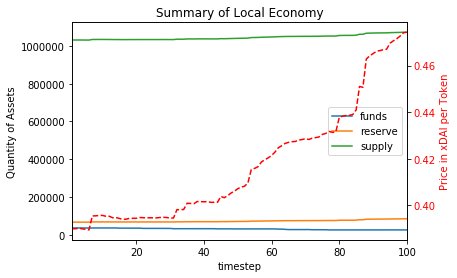

In [87]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

rdf.plot(x='timestep', y=['funds', 'reserve','supply'], ax=ax1)
rdf.plot(x='timestep', y='spot_price',style='--',color = 'red', ax=ax2, legend = False)
ax2.set_ylabel('Price in xDAI per Token', color='red')
ax1.set_ylabel('Quantity of Assets')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Summary of Local Economy')

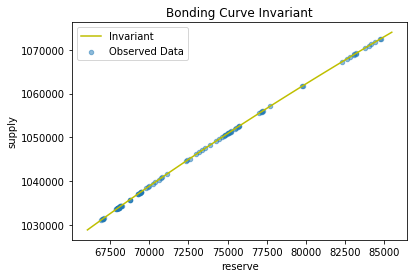

In [88]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, invariant, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

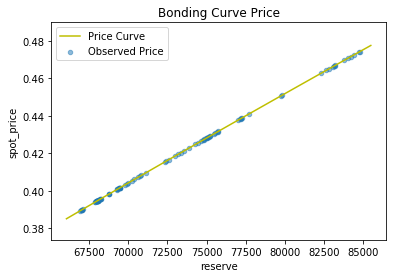

In [89]:
rdf.plot(x='reserve', y='spot_price', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([spot_price(x, invariant, kappa) for x in xrange ])

plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Price')
plt.legend(['Price Curve', 'Observed Price'])

In [90]:
last_net= df.network.values[-1]
last_props=get_nodes_by_type(last_net, 'proposal')
M = len(last_props)
last_parts=get_nodes_by_type(last_net, 'participant')
N = len(last_parts)

In [91]:
affinities = np.empty((N,M))
for i_ind in range(N):
    for j_ind in range(M):
        i = last_parts[i_ind]
        j = last_props[j_ind]
        affinities[i_ind][j_ind] = last_net.edges[(i,j)]['affinity']

Text(0.5, 67.14155844155843, 'participant_id')

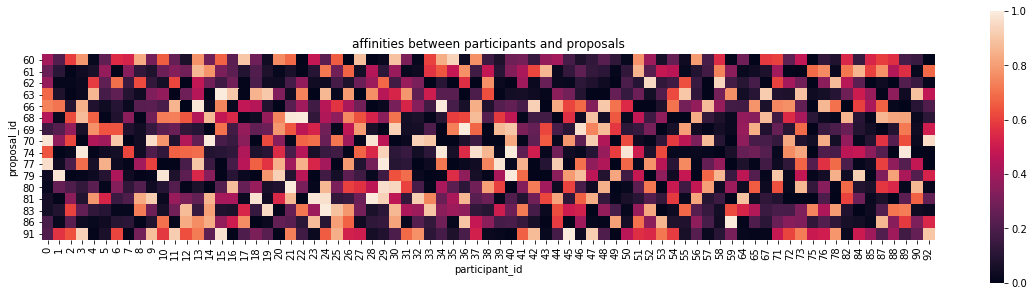

In [92]:
dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)

sns.heatmap(affinities.T,
            xticklabels=last_parts,
            yticklabels=last_props,
            square=True,
            cbar=True,
            ax=ax)

plt.title('affinities between participants and proposals')
plt.ylabel('proposal_id')
plt.xlabel('participant_id')

In [93]:
#working on deduplicating colors
#
#last_props=get_nodes_by_type(last_net, 'proposal')
#M = len(last_props)

#cm = plt.get_cmap('gist_rainbow')
#c= [cm(1.*j/M) for j in range(M)] 

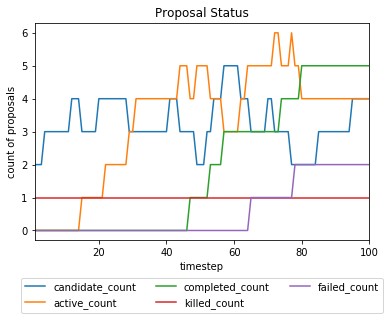

In [111]:
rdf.plot(x='timestep',y=['candidate_count','active_count','completed_count', 'killed_count', 'failed_count'])
plt.title('Proposal Status')
plt.ylabel('count of proposals')
plt.legend(ncol = 3,loc='upper center', bbox_to_anchor=(0.5, -0.15))

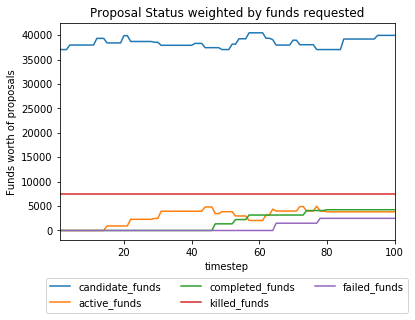

In [112]:
rdf.plot(x='timestep',y=['candidate_funds','active_funds','completed_funds', 'killed_funds', 'failed_funds'])
plt.title('Proposal Status weighted by funds requested')
plt.ylabel('Funds worth of proposals')
plt.legend(ncol = 3,loc='upper center', bbox_to_anchor=(0.5, -0.15))

Text(0, 0.5, 'share_of_funds_requested')

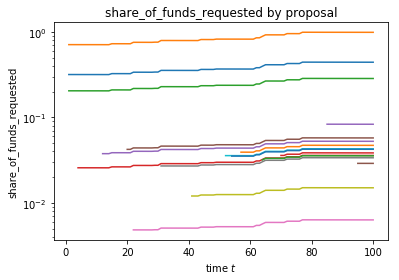

In [96]:
plt.semilogy(rdf.timestep,make2D('share_of_funds_requested_all', rdf))
plt.title('share_of_funds_requested by proposal')
plt.xlabel('time $t$')
plt.ylabel('share_of_funds_requested')

Text(0.5, 0, 'share_of_funds_requested')

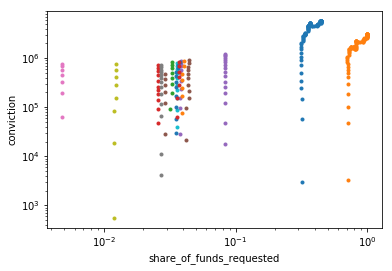

In [97]:
plt.loglog(make2D('share_of_funds_requested_all', rdf), make2D('conviction_all', rdf), '.')
plt.ylabel('conviction')
plt.xlabel('share_of_funds_requested')

Text(0.5, 0, 'proposal_age')

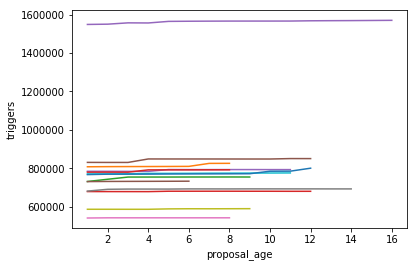

In [98]:
plt.plot(make2D('age_all', rdf), make2D('triggers_all', rdf))
plt.ylabel('triggers')
plt.xlabel('proposal_age')

Text(0.5, 1.0, 'phase: Triggers & Conviction')

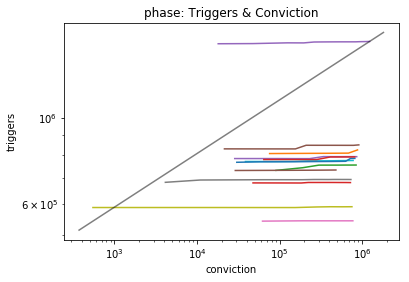

In [99]:
plt.loglog(make2D('conviction_all', rdf), make2D('triggers_all', rdf))
a = plt.axis()
plt.loglog(a[:2],a[2:], 'k',alpha=.5 )
plt.ylabel('triggers')
plt.xlabel('conviction')
plt.title('phase: Triggers & Conviction')

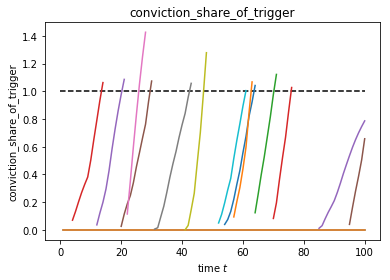

In [100]:
T = time_periods_per_run
plt.plot(rdf.timestep,make2D('conviction_share_of_trigger_all', rdf))
plt.title('conviction_share_of_trigger')
plt.xlabel('time $t$')
plt.ylabel('conviction_share_of_trigger')
plt.hlines(1,0,T, linestyle='--')

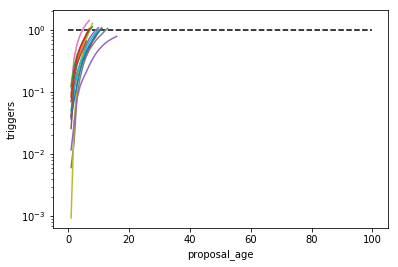

In [101]:
plt.semilogy(make2D('age_all', rdf), make2D('conviction_share_of_trigger_all', rdf))
plt.ylabel('triggers')
plt.xlabel('proposal_age')
plt.hlines(1,0,T, linestyle='--')

In [102]:
nets = rdf.network.values

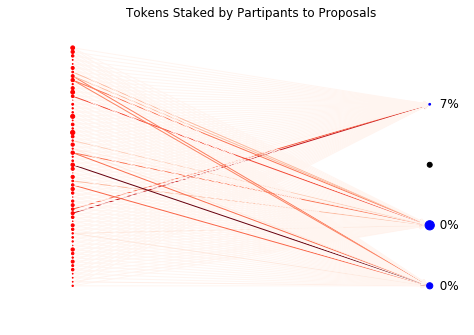

In [126]:
K = 3
snap_plot(nets[K:K+1], size_scale = 1/300)

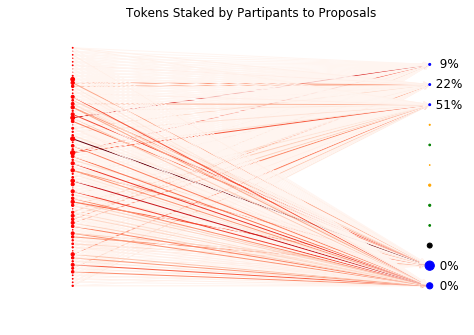

In [125]:
K = 56
snap_plot(nets[K:K+1], size_scale = 1/300)

In [127]:
def quantile_plot(xkey, ykey, dataframe, dq=.1, logy=False, return_df = False):
    qX = np.arange(0,1+dq,dq)
    
    data = dataframe[[xkey,ykey]].copy()
    
    qkeys = []
    for q in qX:
        qkey= 'quantile'+str(int(100*q))
        #print(qkey)
        data[qkey] = data[ykey].apply(lambda arr: np.quantile(arr,q) )
        #print(data[qkey].head())
        qkeys.append(qkey)
    
    data[[xkey]+qkeys].plot(x=xkey,  logy=logy)
        
    plt.title(ykey + " Quantile Plot" )
    plt.ylabel(ykey)
    labels = [str(int(100*q))+"$^{th}$ Percentile" for q in qX ]
    
    plt.legend(labels, ncol = 1,loc='center left', bbox_to_anchor=(1, .5))
    if return_df:
        return data

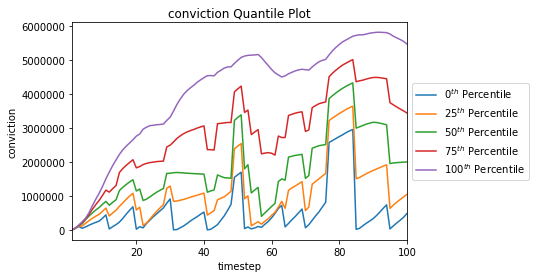

In [128]:
quantile_plot('timestep','conviction', rdf, .25)


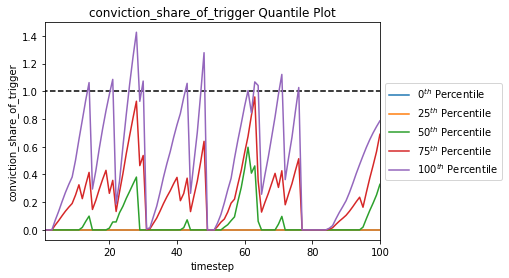

In [129]:
quantile_plot('timestep','conviction_share_of_trigger', rdf, .25)
plt.hlines(1,0,T, linestyle='--')